In [3]:
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tqdm import tqdm
from typing import List, Union, Optional, Callable
import pickle
from Bio import AlignIO, SeqIO
from ete3 import Tree, TreeNode
from gctree import CollapsedTree

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from ete3 import Tree, faces, TreeStyle, NodeStyle, TextFace, SequenceFace, COLOR_SCHEMES, CircleFace
from GCTree_preparation import *
import warnings
import math
import nltk
from matplotlib.patches import Rectangle
warnings.filterwarnings("ignore")

path_to_storage = "/media/hieunguyen/HNHD01/storage/all_BSimons_datasets"
outdir = "/media/hieunguyen/GSHD_HN01/outdir/sc_bulk_BCR_data_analysis_v0.1"

bulk_project = "241031_BSimons"
sc_project = ["241104_BSimons", "241002_BSimons"]

PROJECTS = f"{bulk_project}_{'_'.join(sc_project)}"
mouseid = "m3"

dist_type = "full_seq"
path_to_01_output = f"{outdir}/tree_analysis/{bulk_project}/01_output"
path_to_07_output = f"{outdir}/tree_analysis/07_output/{PROJECTS}/{mouseid}/{dist_type}"
os.system(f"mkdir -p {path_to_07_output}")

with open(f"{path_to_01_output}/saveTreeobj.pkl", "rb") as f:
    saveTreeobj = pickle.load(f)

bulk_metadata = pd.read_excel("/media/hieunguyen/HNSD01/src/sc_bulk_BCR_data_analysis/preprocessing/240826_BSimons/240829 sample sheet.xlsx")
bulk_metadata.columns = ["MID", "mouseID", "organ", "population"]

maindf = pd.read_csv(f"{path_to_01_output}/tree_summarydf.csv")
maindf = maindf[maindf["mouseID"] == mouseid]

path_to_04_output = os.path.join(outdir, "VDJ_output", "04_output")
thres = 0.85
clonedf = pd.read_csv(os.path.join(path_to_04_output, "full_clonedf_with_mutation_rate.csv"), index_col= [0])
clonedf = clonedf[clonedf['num_mutation'] != "region_not_covered-skip"]

sc_clonedf = clonedf[clonedf['dataset.name'].isin(sc_project)][["barcode", "id", 'V.gene', 'J.gene', 'D.gene', "aaSeqCDR3", "nSeqCDR3", "targetSequences"]].reset_index().drop("index", axis = 1)

# path_to_clonesets = f"{outdir}/VDJ_output/03_output/FASTA_output/{bulk_project}/VDJ_output_{thres}/{mouseid}/all/clonesets.csv"
# bulk_clonedf = pd.read_csv(path_to_clonesets)[["id", 'V.gene', 'J.gene', 'D.gene', f'VJcombi_CDR3_{thres}', "aaSeqCDR3", "nSeqCDR3"]]
# bulk_clonedf.columns = ["id", 'V.gene', 'J.gene', 'D.gene', "cloneid", "aaSeqCDR3", "nSeqCDR3"]
# bulk_clonedf["mouseID"] = bulk_clonedf["id"].apply(lambda x: bulk_metadata[bulk_metadata["MID"] == x]["mouseID"].values[0])
# bulk_clonedf = bulk_clonedf[bulk_clonedf["mouseID"] == mouseid]

sc_clonedf["mouseID"] = sc_clonedf["id"].apply(lambda x: "m" + x.replace("M", "").replace("P", ""))
sc_clonedf = sc_clonedf[sc_clonedf["mouseID"] == mouseid]

  0%|          | 0/267 [00:01<?, ?it/s]


NameError: name 'path_to_06_output' is not defined

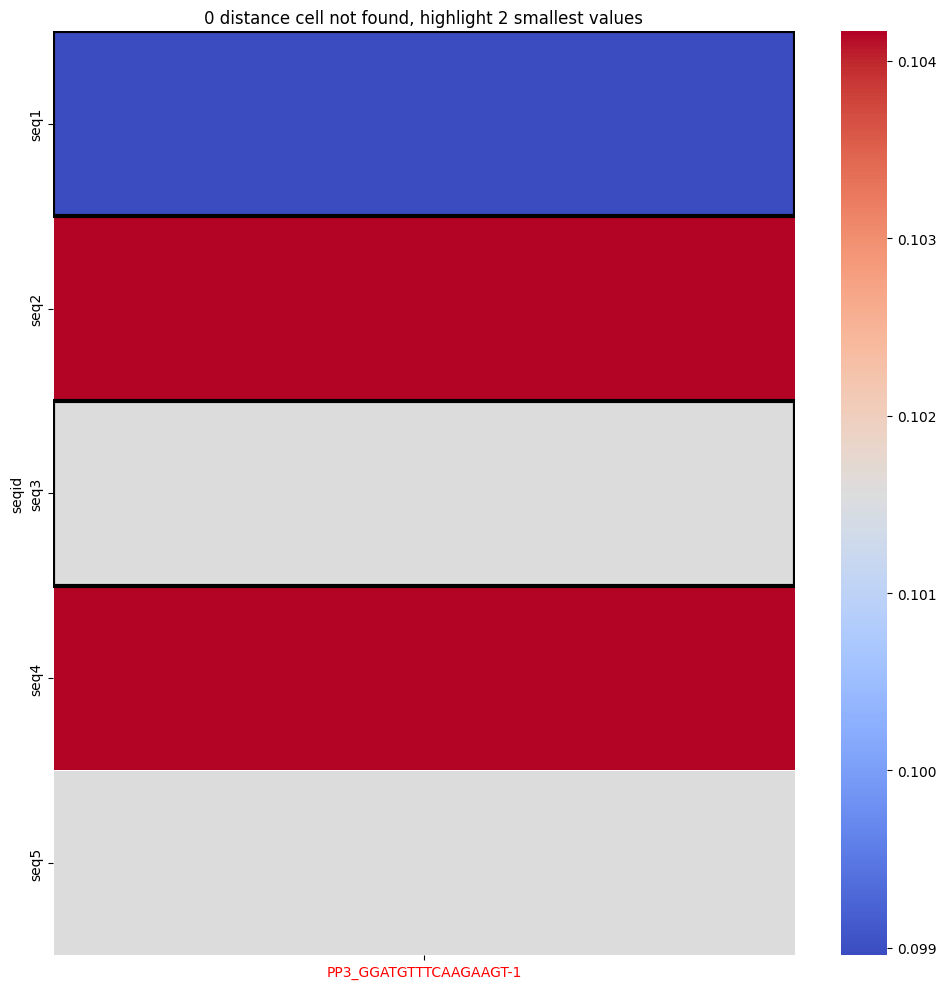

In [4]:
color_path = f"{bulk_project}_color.csv"
tree_dist_seqdf = pd.DataFrame()
scdistdf = pd.DataFrame()
for cloneid in tqdm(maindf.cloneid.unique()):
    os.system(f"mkdir -p {path_to_07_output}/{cloneid}")
    V_gene = cloneid.split("_")[1]
    J_gene = cloneid.split("_")[2]
    cdr3_len = cloneid.split("_")[3]
    mouseid = cloneid.split("_")[0]

    treeobj = saveTreeobj[cloneid]
    seqdf = treeobj.seqdf.copy()
    idmapdf = treeobj.idmapseqdf.copy()
    bulkdf = seqdf.merge(idmapdf, right_on = "seq", left_on = "seq")
    bulkdf["aaSeqCDR3"] = bulkdf["ID"].apply(lambda x: x.split("|")[2].split(":")[1])
    
    scdf = sc_clonedf[(sc_clonedf["V.gene"] == V_gene.split("-0")[0]) & 
                    (sc_clonedf["J.gene"] == J_gene.split("-0")[0])]

    scdf["len"] = scdf["nSeqCDR3"].apply(lambda x: len(x))
    scdf = scdf[scdf["len"] == int(cdr3_len)]
    all_barcodes = [f"{scdf['id'].values[i]}_{scdf['barcode'].values[i]}" for i in range(scdf.shape[0])]
    if scdf.shape[0] > 0:
        for i in range(0, scdf.shape[0]):
            barcode = scdf.iloc[i].barcode
            sampleid = scdf.iloc[i].id
            if dist_type == "CDR3":
                sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["aaSeqCDR3"].values[0] 
                bulkdf[f"{sampleid}_{barcode}"] = bulkdf["aaSeqCDR3"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
            elif dist_type == "full_seq":   
                sc_seq = scdf[(scdf["barcode"] == barcode) & (scdf["id"] == sampleid)]["targetSequences"].values[0] 
                bulkdf[f"{sampleid}_{barcode}"] = bulkdf["seq"].apply(lambda x: nltk.edit_distance(x, sc_seq)/len(x))
            else:
                raise ValueError("dist_type should be either 'CDR3' or 'full_seq'")
        bulkdf["min_dist_to_a_cell"] = bulkdf[[item for item in bulkdf.columns if sampleid in item]].apply(lambda x: min(x), axis = 1)
        bulkdf["cloneid"] = cloneid
        bulkdf.to_csv(os.path.join(path_to_07_output, cloneid, f"tree_Seqdf_{cloneid}.csv"))
        bulkdf_simplified = bulkdf[["cloneid","ID", "seq", "abundance", "MID", "seqid", "min_dist_to_a_cell"]]
        
        tree_dist_seqdf = pd.concat([tree_dist_seqdf, bulkdf_simplified], axis = 0)
        
        ##### Generate heatmap and save
        heatmap_plotdf = bulkdf[["seqid"] + [item for item in bulkdf.columns if "_" in item and item != "min_dist_to_a_cell"]]
        heatmap_plotdf = heatmap_plotdf[~heatmap_plotdf["seqid"].duplicated()].set_index("seqid")
        plt.figure(figsize= (10, 10))
        sns.heatmap(heatmap_plotdf,
                    cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='white')
        for tick_label in plt.gca().get_xticklabels():
            tick_text = tick_label.get_text()
            if "M" in tick_text:
                tick_label.set_color('blue')
            elif "P" in tick_text:
                tick_label.set_color('red')
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_07_output, cloneid, f"heatmap_{cloneid}.svg"))
        plt.close()

        coordinates = list(zip(*np.where(heatmap_plotdf.values == 0)))
        title = "Found 0 distance cell"
        fill = False
        if len(coordinates) == 0:
            title = "0 distance cell not found, highlight 2 smallest values"
            smallest_value_coords = {}
            coordinates = []
            for col in heatmap_plotdf.columns:
                min_vals = sorted(heatmap_plotdf[col].unique())[0:2]
                min_idx1 = heatmap_plotdf[heatmap_plotdf[col] == min_vals[0]].index[0]
                min_idx2 = heatmap_plotdf[heatmap_plotdf[col] == min_vals[1]].index[0]
                coord1 = np.where(heatmap_plotdf.index == min_idx1)[0][0]
                coord2 = np.where(heatmap_plotdf.index == min_idx2)[0][0]
                smallest_value_coords[col] = (coord1, coord2)
            for i in range(heatmap_plotdf.shape[1]):
                barcode = heatmap_plotdf.columns[i]
                y1 = smallest_value_coords[barcode][0]
                y2 = smallest_value_coords[barcode][1]
                x = np.int64(i)
                y1 = np.int64(y1)
                y2 = np.int64(y2)
                coordinates.append((y1, x))
                coordinates.append((y2, x))
        plt.figure(figsize= (10, 10))
        ax = sns.heatmap(heatmap_plotdf,
                    cmap="coolwarm", cbar=-1, linewidths=0.5, linecolor='white')
        for tick_label in plt.gca().get_xticklabels():
            tick_text = tick_label.get_text()
            if "M" in tick_text:
                tick_label.set_color('blue')
            elif "P" in tick_text:
                tick_label.set_color('red')

        for i in range(len(coordinates)):
            ax.add_patch(Rectangle((coordinates[i][1], coordinates[i][0]),1,1, fill=fill, edgecolor='black', lw=3))
        plt.title(title)
        plt.tight_layout()
        plt.savefig(os.path.join(path_to_06_output, cloneid, f"heatmap_{cloneid}.annotated.svg"))
        plt.close()

        ##### generate tree and save
        treeobj = saveTreeobj[cloneid] 
        avai_mids = treeobj.seqdf["MID"].unique()
        mid_color_pal = pd.read_csv(color_path, index_col = [0]).to_dict()["hex color"]

        ts = treeobj.generate_tree_style(color_path = color_path)

        for input_mid in avai_mids:
            if input_mid == "GL":
                input_mid_col = "gray"
            else:
                input_mid_col = mid_color_pal[input_mid]
            ts.legend.add_face(CircleFace(10, input_mid_col), column = 0)
            ts.legend.add_face(TextFace(bulk_metadata[bulk_metadata["MID"]==input_mid]["population"].values[0]), column = 0)
    
        treeobj.tree.render(f"{path_to_07_output}/{cloneid}/{cloneid}.tree.svg", tree_style = ts)
    else:
        bulkdf.to_csv(os.path.join(path_to_07_output, f"tree_Seqdf_{cloneid}.csv"))
    tmp_scdistdf = bulkdf[[item for item in bulkdf.columns if item in all_barcodes]].min().reset_index()
    tmp_scdistdf.columns = ["barcode", "min_dist_to_a_tree"]
    tmp_scdistdf["treeID"] = cloneid
    scdistdf = pd.concat([scdistdf, tmp_scdistdf], axis = 0)
    
tree_dist_seqdf.to_csv(os.path.join(path_to_07_output, "tree_dist_seqdf.csv"))
scdistdf.to_csv(os.path.join(path_to_07_output, "scdistdf.csv"))
